In [1]:
import os
import jax
import jax.numpy as jnp
from jax import jit
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output

plt.rcParams.update({
    "text.usetex": True,          # Use LaTeX for all text
    "font.family": "serif",       # Use serif font (LaTeX default)
    "font.size": 20,              # Font size
})

In [29]:
# Performance optimizations
import os
import jax
import jax.numpy as jnp
from jax import jit
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output

# Configure JAX for better performance
jax.config.update("jax_enable_x64", True)  # Use 64-bit precision
print(f"JAX backend: {jax.default_backend()}")
print(f"Available devices: {jax.devices()}")

# Set memory allocation strategy
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.8'

plt.rcParams.update({
    "text.usetex": True,          # Use LaTeX for all text
    "font.family": "serif",       # Use serif font (LaTeX default)
    "font.size": 20,              # Font size
})

JAX backend: cpu
Available devices: [CpuDevice(id=0)]


In [66]:
# SPATIAL GRID
N = 256
L = 4 * np.pi

# Use JAX arrays from the start for better performance
x = jnp.linspace(0, L, N, endpoint=False)
y = jnp.linspace(0, L, N, endpoint=False)
X, Y = jnp.meshgrid(x, y, indexing='ij')

kx = jnp.fft.fftfreq(N) * N
ky = jnp.fft.fftfreq(N) * N
KX, KY = jnp.meshgrid(kx, ky, indexing='ij')
K2 = (KX**2 + KY**2).at[0,0].set(1.0) # |k|^2
symbol = -(KX * KY / K2) # symbol of R1^2
symbol = symbol.at[0,0].set(0.0)

@jit
def R12(f):
    """Compute R1^2 f using FFT."""
    f_hat = jnp.fft.fft2(f)
    return jnp.fft.ifft2(symbol * f_hat).real

In [67]:
def plot(omega, save=False, filename="", title=""):
    """Optimized plotting function that handles both JAX and NumPy arrays."""
    # Convert to NumPy if needed (only when plotting)
    if hasattr(omega, 'device'):  # JAX array
        omega_np = np.array(omega)
        X_np = np.array(X)
        Y_np = np.array(Y)
    else:  # Already NumPy
        omega_np = omega
        X_np = X if isinstance(X, np.ndarray) else np.array(X)
        Y_np = Y if isinstance(Y, np.ndarray) else np.array(Y)
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    skip = N // 100  # Adjust skip for performance
    X_np = X_np[::skip, ::skip]
    Y_np = Y_np[::skip, ::skip]
    omega_np = omega_np[::skip, ::skip]
    ax.plot_surface(X_np, Y_np, omega_np, cmap='inferno', edgecolor='none', antialiased=True)
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")
    ax.set_zlabel(r"$\omega$")
    
    if title:  ax.set_title(title)
    if save: plt.savefig(filename, bbox_inches='tight', pad_inches=0.3)
    
    plt.show()

In [68]:
# INITIAL CONDITION
omega0 = jnp.sin(X) * jnp.sin(Y)
# plot(omega0, save=True, filename="plots/2d/R12_T/R12_initial_condition.pdf")

In [69]:
# RHS - Ultra-optimized version
k_cut = N / L * (1/5)  # 2/3 dealiasing cutoff
dealias_mask_jax = jnp.where(jnp.sqrt(K2) <= k_cut, 1.0, 0.0)

@jit
def get_rhs(w):
    """Ultra-optimized RHS computation with dealiasing in Fourier space."""
    # Single FFT to Fourier space
    w_hat = jnp.fft.fft2(w)
    
    # Compute R12(w) in Fourier space (no extra FFT needed)
    R12_w_hat = symbol * w_hat
    R12_w = jnp.fft.ifft2(R12_w_hat).real
    
    # Nonlinear term w * R12(w)
    nonlin = w * R12_w
    
    # Transform to Fourier space and apply dealiasing
    nonlin_hat = jnp.fft.fft2(nonlin) * dealias_mask_jax
    
    # Return to real space
    return jnp.fft.ifft2(nonlin_hat).real

@jit
def euler_step(omega, dt):
    return omega + dt * get_rhs(omega)
    omega_new = omega + dt * get_rhs(omega)

    return jnp.fft.ifft2(jnp.fft.fft2(omega_new) * dealias_mask_jax).real

@jit
def rk4_step(omega, dt):
    k1 = get_rhs(omega)
    k2 = get_rhs(omega + 0.5 * dt * k1)
    k3 = get_rhs(omega + 0.5 * dt * k2)
    k4 = get_rhs(omega + dt * k3)

    return omega + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

    omega_new = omega + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    
    return jnp.fft.ifft2(jnp.fft.fft2(omega_new) * dealias_mask_jax).real

@jit
def compute_max_abs(arr):
    """JIT-compiled function to compute max absolute value."""
    return jnp.max(jnp.abs(arr))

@jit 
def compute_max_fft_abs(arr):
    """JIT-compiled function to compute max absolute value of FFT."""
    return jnp.max(jnp.abs(jnp.fft.fft2(arr)))

In [70]:
# Optimized main computation loop
omega = omega0.copy()  # Start with JAX array
T = 5.6
dt = 1e-2
nsteps = int(T / dt)

# Pre-allocate arrays with JAX for better performance
maxs = jnp.zeros(nsteps)
max_freqs = []
save_every = 10
saved_solutions = []

rk4 = False
step_fn = rk4_step if rk4 else euler_step

# Pre-compile the step function
print("Pre-compiling functions...")
_ = step_fn(omega, dt)
_ = compute_max_abs(omega)
_ = compute_max_fft_abs(omega)

# Optimized loop - minimize host-device transfers
print("Starting computation...")
for n in range(nsteps):
    omega = step_fn(omega, dt)
    
    # Compute max efficiently using JIT-compiled function
    max_val = compute_max_abs(omega)
    maxs = maxs.at[n].set(max_val)
    
    if (n + 1) % save_every == 0:
        # Only transfer to host when needed for saving
        w_host = np.array(omega)
        saved_solutions.append((n+1, w_host))
        
        # Compute max frequency efficiently
        max_freq = compute_max_fft_abs(omega)
        max_freqs.append(float(max_freq))

        print(f"Step {n+1}/{nsteps}, max|omega| = {float(max_val):.5f}, max|FFT(omega)| = {float(max_freq):.5f}")

Pre-compiling functions...
Starting computation...
Step 10/560, max|omega| = 1.00000, max|FFT(omega)| = 16384.00000
Step 20/560, max|omega| = 1.00000, max|FFT(omega)| = 16384.00000
Step 30/560, max|omega| = 1.00000, max|FFT(omega)| = 16384.00000
Step 40/560, max|omega| = 1.00000, max|FFT(omega)| = 16384.00000
Step 50/560, max|omega| = 1.00000, max|FFT(omega)| = 16384.00000
Step 60/560, max|omega| = 1.00000, max|FFT(omega)| = 16384.00000
Step 70/560, max|omega| = 1.00000, max|FFT(omega)| = 16384.00000
Step 80/560, max|omega| = 1.00000, max|FFT(omega)| = 16384.00000
Step 90/560, max|omega| = 1.00000, max|FFT(omega)| = 16384.00000
Step 100/560, max|omega| = 1.00000, max|FFT(omega)| = 16384.00000
Step 110/560, max|omega| = 1.00000, max|FFT(omega)| = 16384.00000
Step 120/560, max|omega| = 1.00000, max|FFT(omega)| = 16384.00000
Step 130/560, max|omega| = 1.00000, max|FFT(omega)| = 16384.00000
Step 140/560, max|omega| = 1.00000, max|FFT(omega)| = 16384.00000
Step 150/560, max|omega| = 1.00000

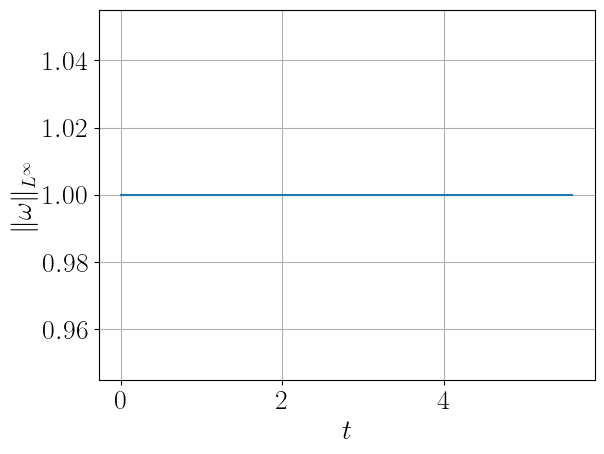

[16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0]


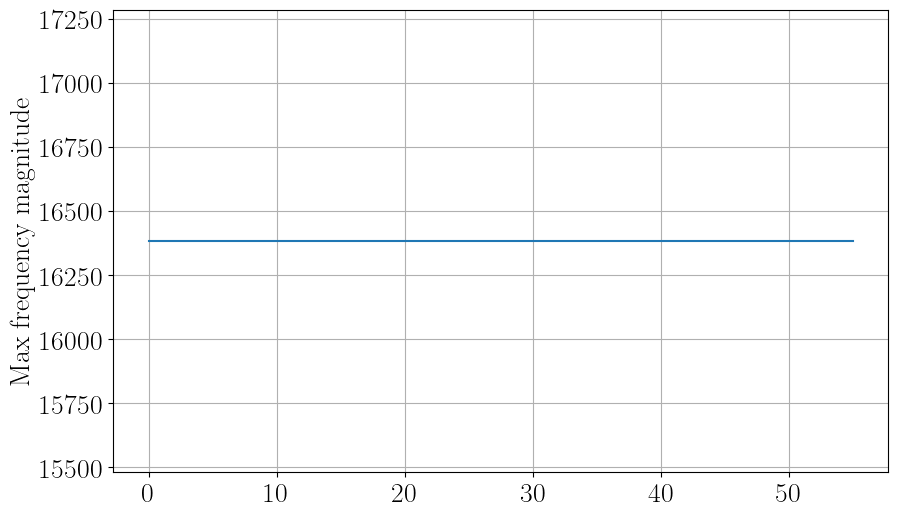

In [71]:
times = jnp.arange(nsteps) * dt

# plots L^infty norm
maxs_np = np.array(maxs)

plt.plot(times, 1 / maxs_np)
plt.grid()
plt.xlabel(r"$t$")
plt.ylabel(r"$\|\omega\|_{L^{\infty}}$")
# plt.yscale('log')
# plt.xticks([0, 1.0, 2.0, 3.0, 4.0, 5.0, 5.4], fontsize=16)
# plt.yticks([0, 100, 200, 300, 400, 500, 600, 700], fontsize=16)
# plt.yscale('log')
plt.savefig(f"plots/2d/R12_T{"_rk4" if rk4 else ""}/R12_max_omega.pdf", bbox_inches='tight')
plt.show()

# plots max frequency
print(max_freqs)
if max_freqs:
    plt.figure(figsize=(10, 6))
    plt.plot(max_freqs)
    plt.ylabel("Max frequency magnitude")
    plt.grid()
    plt.show()

In [72]:
# save all snapshots
output_dir = f"plots/2d/R12_T{'_rk4' if rk4 else ''}"
os.makedirs(f"{output_dir}/time", exist_ok=True)

for step_num, omega_snap in saved_solutions:
    clear_output(wait=True)
    plot(omega_snap, save=True, filename=f"{output_dir}/R12_step_{step_num}.pdf")
    plot(omega_snap, save=True, filename=f"{output_dir}/time/R12_step_{step_num}_with_timestamp.pdf", title=rf"2d - RK4 - $t={step_num * dt:.2f}$")

KeyboardInterrupt: 